# QA Phantom Analysis

In [6]:
from __future__ import division
import dicom as dcm
import dcmextras.seriesio as dcmio
import dcmextras.siemenscsa as csa
import dcmextras.siemensoog as oog
from dcmfetch.queryinterface import QueryInterface, QIError
from dcmfetch.aettable import AetTable

import os
import platform

# Details of CRIC's DICOM Server
DFLT_LOCAL_AET = platform.node().split('.')[0] + 'Store'
aetable = AetTable('./dcmnodes.cf') if os.path.exists('./dcmnodes.cf') else AetTable('/etc/dcmnodes.cf')
qi = QueryInterface(aetable, DFLT_LOCAL_AET)
server = 'Dcm4Chee'

In [7]:
patid = 'PQA20130815RHD'
stuid = '1'

 - Series 8,9,10,11,12,13: 32 channel, oil phantom, SNR, uniformity. Series 8, 10, 12, are unnormalised, 9, 11, 13, are prescan normalised. Within each series there is a pair of identical images to be subtracted for the SNR calculation.
 - 


### 32 Channel Head Coil SNR and Uniformity

Tools to generate masks of circular phantom.

In [8]:
import cv
# This is in fact the v2 bindings that use numpy arrays directly.

def phantom_mask_2d(image, mode=None):
    ''' Generate an eroded mask of the phantom using an Otsu Threshold
        This uses OpenCV. The cv2 interface uses numpy arrays natively.
        
        Parameters
        ----------
        image: Numpy rank-2 image array (ny,nx)
        
        Returns
        -------
        Numpy 8 bit mask array of same dimensions
    '''
    
    # Scale to 8 bit image and smooth
    cv_grey = np.asarray(image*(255.0/np.max(image)), 'uint8')
    cv.Smooth(cv_grey, cv_grey, cv.CV_MEDIAN)
    
    # Threshold binary image (0 or 255) mask
    cv_mask = np.zeros(image.shape, 'uint8')
    threshold, maxval, opts = 0, 255, cv.CV_THRESH_BINARY | cv.CV_THRESH_OTSU    
    cv.Threshold(cv_grey, cv_mask, threshold, maxval, opts)    

    if mode == 'Erode':
        # Erode the mask
        struct_elmnt = cv.CreateStructuringElementEx(cols=3, rows=3,
                                                 anchorX=1, anchorY=1,
                                                 shape=cv.CV_SHAPE_RECT)        
        cv.Erode(src=cv_mask, dst=cv_mask ,element=struct_elmnt, iterations=2)
    elif mode == 'Dilate':
        struct_elmnt = cv.CreateStructuringElementEx(cols=3, rows=3,
                                                 anchorX=1, anchorY=1,
                                                 shape=cv.CV_SHAPE_RECT)        
        cv.Dilate(src=cv_mask, dst=cv_mask ,element=struct_elmnt, iterations=2)    

    return cv_mask

Combinations of DICOM images

In [9]:
def mean_im(dobja, dobjb):
    '''Mean image as numpy array based on two dicom images.
    '''
    imagea, imageb = dobja.pixel_array, dobjb.pixel_array
    imagea &= (2**dobja.BitsStored - 1)
    imageb &= (2**dobjb.BitsStored - 1)
    return (imagea + imageb).astype(np.float64) / 2

def diff_im(dobja, dobjb):
    '''Difference image as numpy array based on two dicom images.
    '''
    imagea, imageb = dobja.pixel_array, dobjb.pixel_array
    imagea &= (2**dobja.BitsStored - 1)
    imageb &= (2**dobjb.BitsStored - 1)
    return imagea.astype(np.float64) - imageb.astype(np.float64)

def snr_im(dobja, dobjb):
    mean_image, diff_image = mean_im(dobja, dobjb), diff_im(dobja, dobjb)
    mask = phantom_mask_2d(mean_image, mode='Erode')
    mean_image = ma.masked_where(mask == 0, mean_image)
    diff_image = ma.masked_where(mask == 0, diff_image)
    return np.sqrt(2) * mean_image / diff_image

def snr(dobja, dobjb):
    '''Returns the Signal to Noise ratio as determined from two images of the Oil filled spherical phantom.
    '''
    mean_image, diff_image = mean_im(dobja, dobjb), diff_im(dobja, dobjb)
    mask = phantom_mask_2d(mean_image, mode='Erode')
    mean_image = ma.masked_where(mask == 0, mean_image)
    diff_image = ma.masked_where(mask == 0, diff_image)
    return np.sqrt(2) * mean_image.mean() / diff_image.std()


In [10]:
from tempfile import mkdtemp
from shutil import rmtree

def fetch_series(patid, sernos, server='Dcm4Chee'):

    # Details of CRIC's DICOM Server
    DFLT_LOCAL_AET = platform.node().split('.')[0] + 'Store'
    aetable = AetTable('./dcmnodes.cf') if os.path.exists('./dcmnodes.cf') else AetTable('/etc/dcmnodes.cf')
    qi = QueryInterface(aetable, DFLT_LOCAL_AET)

    seriess = [s for s in qi.combo_find(server, patid) if s.seriesnumber in sernos]
    # Fetch series from server to a temporary directory and read from there
    tempdir = mkdtemp()

    # NB Returns a generator hence list() to force iteration
    for series in seriess:
        list(qi.series_level_fetch(server,
                      patid=patid, studyuid=series.studyuid, seriesuid=series.seriesuid,
                      savedir=tempdir))

    dobjs = sorted(dcmio.read_series(tempdir, globspec='*'), key=lambda d: (d.SeriesNumber, d.InstanceNumber))
    rmtree(tempdir)
    return dobjs

### Signal to Noise and Uniformity of Oil filed sphere in 32 Channel Head Coil

First, load the images from the server.

In [6]:
sernos = [8, 9]
seriess = [s for s in qi.combo_find(server, patid) if s.seriesnumber in sernos]

# Fetch series from server to a temporary directory and read from there
from tempfile import mkdtemp
from shutil import rmtree
tempdir = mkdtemp()

# NB Returns a generator hence list() to force iteration
for series in seriess:
    list(qi.series_level_fetch(server,
                      patid=patid, studyuid=series.studyuid, seriesuid=series.seriesuid,
                      savedir=tempdir))

dobjs = sorted(dcmio.read_series(tempdir, globspec='*'), key=lambda d: (d.SeriesNumber, d.InstanceNumber))
rmtree(tempdir)

Then we'll generate a mask for the interior of the phantom and calculate the SNR ratio, firstly for the un-normalised images and then for the those normalised with *prescan normalize*. The purple overlay is the mask used.

In [7]:
mean_image, diff_image = mean_im(dobjs[1], dobjs[0]), diff_im(dobjs[1], dobjs[0])
fig, axs = subplots(1, 2, figsize=(8, 4))

im = axs[0].imshow(mean_image, cmap='bone')
axs[0].axis('image')
axs[0].axis('off')
axs[0].set_title(r'Mean Image (Raw)')

mask = phantom_mask_2d(mean_image, mode='Erode')
mask = ma.masked_where(mask == 0, np.ones(mask.shape))
im = axs[0].imshow(mask, cmap='rainbow', alpha=0.25)

im = axs[1].imshow(diff_image, vmin=np.min(diff_image)/10, vmax=np.max(diff_image)/10, cmap='jet')
axs[1].axis('image')
axs[1].axis('off')
axs[1].set_title(r'Difference Image (Raw)')


print 'SNR (Un-normalized Images) =', snr(dobjs[0], dobjs[1])

SNR (Un-normalized Images) = 367.675453839


SNR (Normalized Images) = 387.924546022


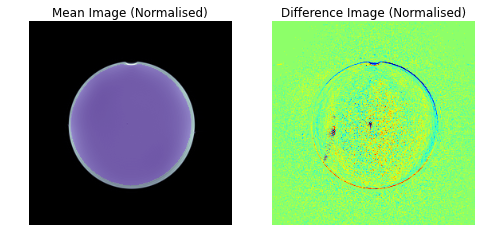

In [8]:
mean_image, diff_image = mean_im(dobjs[4], dobjs[3]), diff_im(dobjs[4], dobjs[3])

fig, axs = subplots(1, 2, figsize=(8, 4))

im = axs[0].imshow(mean_image, cmap='bone')
axs[0].axis('image')
axs[0].axis('off')
axs[0].set_title(r'Mean Image (Normalised)')

mask = phantom_mask_2d(mean_image, mode='Erode')
mask = ma.masked_where(mask == 0, np.ones(mask.shape))
im = axs[0].imshow(mask, cmap='rainbow', alpha=0.25)

im = axs[1].imshow(diff_image, vmin=np.min(diff_image)/10, vmax=np.max(diff_image)/10, cmap='jet')
axs[1].axis('image')
axs[1].axis('off')
axs[1].set_title(r'Difference Image (Normalised)')

print 'SNR (Normalized Images) =', snr(dobjs[3], dobjs[4])

Show all the images in the series.

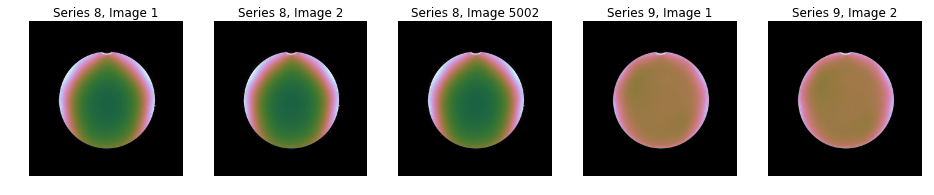

In [9]:
images = [d.pixel_array & 0xfff for d in dobjs]
nimages = len(images)
fig, axs = subplots(1, nimages, figsize=(16, 4))
for i in range(nimages):
    im = axs[i].imshow(images[i], cmap='cubehelix')
    axs[i].axis('image')
    axs[i].axis('off')
    axs[i].set_title(r'Series %d, Image %d' % (dobjs[i].SeriesNumber, dobjs[i].InstanceNumber))


IPEM 80 fractional uniformity analysis. We look at a (thick) profile through the centre of the phantom and determine the length of the longest run that is within 10% of the modal value.

IPEM 80 Uniformity:
    Fractional Uniformity (Raw) =  35%
    Fractional Uniformity (PSN) =  78%


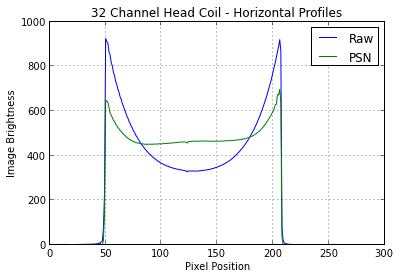

In [10]:
from scipy.ndimage.measurements import center_of_mass as cofm
from scipy import stats
from numpy import ma
import itertools

# Find the centre of mass of the phantom in the image
x, y = cofm(phantom_mask_2d(images[3]))
x, y = int(round(x)), int(round(y))

# Profiles through the centres of the raw and pre-scan normalized images
image_raw = (images[0] + images[1])/2
image_psn = (images[3] + images[4])/2
profile_raw = np.mean(image_raw[y-3:y+4], axis=0)
profile_psn = np.mean(image_psn[y-3:y+4], axis=0)

# Modal values in 10x10 ROI at centre of phantom
modal_val_raw = stats.mode(image_raw[y-4:y+5, x-4:x+5], axis=None)[0]
modal_val_psn = stats.mode(image_psn[y-4:y+5, x-4:x+5], axis=None)[0]

# The proportion of the profile with 10% of the modal value
near_mode_raw  = list((0.9*modal_val_raw < profile_raw) & (profile_raw < 1.1*modal_val_raw))
in_phantom_raw = list(0.25*np.max(image_raw) < profile_raw)

run_near_mode_raw  = np.max([np.sum(list(g)) for b, g in itertools.groupby(near_mode_raw)  if b])
run_in_phantom_raw = np.max([np.sum(list(g)) for b, g in itertools.groupby(in_phantom_raw) if b])

percent_uniformity_raw = run_near_mode_raw/run_in_phantom_raw * 100

near_mode_psn  = list((0.9*modal_val_psn<profile_psn) & (profile_psn<1.1*modal_val_psn))
in_phantom_psn = list(0.25*np.max(image_psn)<profile_psn)

run_near_mode_psn  = np.max([np.sum(list(g)) for b, g in itertools.groupby(near_mode_psn)  if b])
run_in_phantom_psn = np.max([np.sum(list(g)) for b, g in itertools.groupby(in_phantom_psn) if b])

percent_uniformity_psn = run_near_mode_psn/run_in_phantom_psn * 100

print 'IPEM 80 Uniformity:'
print '    Fractional Uniformity (Raw) = %3.0f%%' % percent_uniformity_raw
print '    Fractional Uniformity (PSN) = %3.0f%%' % percent_uniformity_psn

plot(profile_raw, label='Raw')
hold(True)
plot(profile_psn, label='PSN')
xlabel('Pixel Position')
ylabel('Image Brightness')
title('32 Channel Head Coil - Horizontal Profiles')
legend()
grid(True)

### Slice Thickness and Geometric Distortion in TO2

Get the series.

In [11]:
sernos = [59]
seriess = [s for s in qi.combo_find(server, patid) if s.seriesnumber in sernos]

# Fetch series from server to a temporary directory and read from there
from tempfile import mkdtemp
from shutil import rmtree
tempdir = mkdtemp()

# NB Returns a generator hence list() to force iteration
for series in seriess:
    list(qi.series_level_fetch(server,
                      patid=patid, studyuid=series.studyuid, seriesuid=series.seriesuid,
                      savedir=tempdir))

dobjs = sorted(dcmio.read_series(tempdir, globspec='*'), key=lambda d: (d.SeriesNumber, d.InstanceNumber))
rmtree(tempdir)

(4, 4)


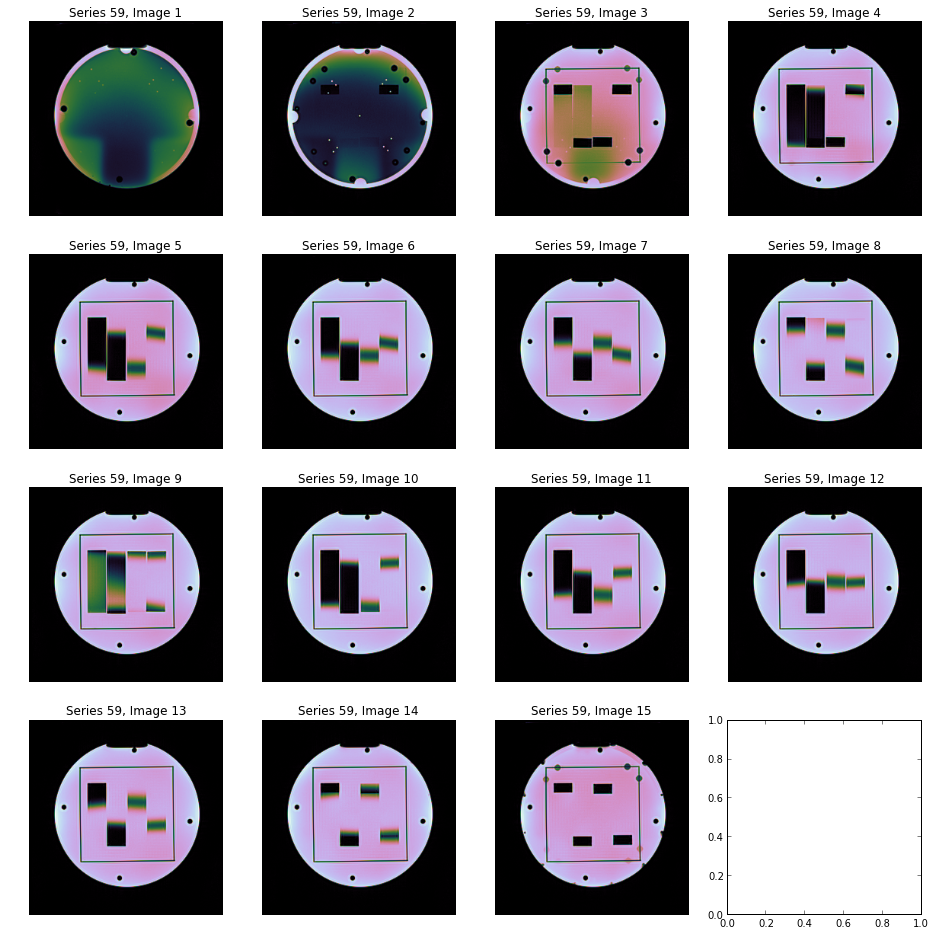

In [12]:
images = [d.pixel_array & 0xfff for d in dobjs]
nimages = len(images)
nx = int(round(sqrt(nimages)))
ny = int(ceil(nimages/nx))
fig, axs = subplots(ny, nx, figsize=(4*nx, 4*ny))
print axs.shape
for i in range(nimages):
    im = axs[i//nx, i%nx].imshow(images[i], cmap='cubehelix')
    axs[i//nx, i%nx].axis('image')
    axs[i//nx, i%nx].axis('off')
    axs[i//nx, i%nx].set_title(r'Series %d, Image %d' % (dobjs[i].SeriesNumber, dobjs[i].InstanceNumber))

The phantom has two crossed plates and two pairs of wedges. It could be quite tricky to find them automatically. We should be able to find the phantom, fit a circle or otherwise eliminate the bubble, then locate the bolt holes which are at a fixed distance from the edge and approximately the same position on each slice. From this, assuming the phantom is the right way up, we should be able to put profiles over the wedges and plates. If we then find the slices where the profiles are closest together (most symmetric) with the constraint that the two best positions are separatred by the known difference in the plate positions. We want thick profiles for SNR but they can be rather bent - can we realign them? For the 3mm case we really want to use the blocks and differentiate the profile - but this could get pretty noisy. Remember that we want the profile in mm so we have to scale by the pixel size and the projection factor $\tan 11.3^{\circ}$

Let's generate a mask, fill it a bit ..

In [13]:
from skimage.transform import rescale
from skimage.exposure import rescale_intensity
print amax(images[9]), images[9].shape, images[9].dtype, sum(images[9])
images = [rescale_intensity(rescale(i, (2,2), order=2))  for i in images]
print amax(images[9]), images[9].shape, images[9].dtype, sum(images[9])

2541 (256, 256) uint16 47000607
1.0 (512, 512) float64 71696.5561649


In [14]:
# We'll arbitarily choose image 10 for the mask:
image = images[9].copy()

# Background image
fig, axs = subplots(1, 3, figsize=(12, 4))
im = axs[0].imshow(image, cmap='bone')
axs[0].axis('image')
axs[0].axis('off')

im = axs[1].imshow(image, cmap='bone')
axs[1].axis('image')
axs[1].axis('off')
axs[1].set_title(r'Phantom and Mask')
im = axs[2].imshow(image, cmap='bone')
axs[2].axis('image')
axs[2].axis('off')
axs[2].set_title(r'Phantom and Mask')

# Initial mask
mask = phantom_mask_2d(image)

# Fill interior of mask
from scipy.ndimage import morphology 
mask = morphology.binary_fill_holes(mask)

#mask = morphology.binary_dilation(mask, iterations=5)

# Find boundary points on mask
dist_interior = morphology.distance_transform_edt(mask)
dist_exterior = morphology.distance_transform_edt(logical_not(mask))
boundary = (dist_interior <= 1) & (dist_exterior <= 1)
indices = nonzero(boundary)
xs = array(list(squeeze(indices[0])))
ys = array(list(squeeze(indices[1])))

# Fit a circle to them using non-linear least squares
from scipy import optimize

def calc_R(xc, yc, xs, ys):
    """ Calculate the distance of each 2D points from the centre (xc, yc) """
    return sqrt((xs-xc)**2 + (ys-yc)**2)

def f_2(c, xs, ys):
    """ Calculate the algebraic distance between the data points and the mean circle centred at c=(xc, yc) """
    Ri = calc_R(*c, xs=xs, ys=ys)
    return Ri - Ri.mean()

# Use centroid as initial centre estimate
centre_estimate = cofm(phantom_mask_2d(images[3]))

print 'Guess  Centre is at ', centre_estimate
centre_2, ier = optimize.leastsq(f_2, centre_estimate, args=(xs, ys))

xc_2, yc_2 = centre_2
Ri_2       = calc_R(*centre_2, xs=xs, ys=ys)
R_2        = Ri_2.mean()

print 'Fitted Centre is at ', tuple(centre_2)
print 'Fitted Radius is at ', R_2

# NB we seem to have got x and y exchanged here

mask = ma.masked_where(mask == 0, np.ones(mask.shape))
axs[0].imshow(mask, cmap='rainbow', alpha=0.9)
axs[0].add_artist(Circle((yc_2, xc_2), radius=R_2, color='g', alpha=0.5))
axs[0].add_artist(Circle((5, 10), radius=5, color='r', alpha=0.75))
axs[0].set_title(r'Phantom and Mask')

axs[1].imshow(dist_interior, cmap='rainbow', alpha=0.5)
axs[1].add_artist(Circle((yc_2, xc_2), radius=R_2, color='g', alpha=0.5))
axs[1].add_artist(Circle((5, 10), radius=5, color='r', alpha=0.75))
axs[1].set_title(r'Phantom and Interior Dist. Map')

axs[2].imshow(dist_exterior, cmap='rainbow', alpha=0.5)
axs[2].add_artist(Circle((yc_2, xc_2), radius=R_2, color='g', alpha=0.5))
axs[2].add_artist(Circle((5, 10), radius=5, color='r', alpha=0.75))
axs[2].set_title(r'Phantom and Exterior Dist. Map')

# Looks to be a slight offset - maybe non circularity in the phantom
pass

Guess  Centre is at  (249.30449208230098, 264.58813961003983)
Fitted Centre is at  (250.20264208748404, 257.13495752403156)
Fitted Radius is at  189.263101246


In [15]:
from skimage import data, filter, color
from skimage.transform import hough_circle
from skimage.feature import peak_local_max
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

# Load picture and detect edges
image = images[9].copy()
print amin(image), amax(image)
edges = filter.canny(image, sigma=1, low_threshold=0.5, high_threshold=0.75)
#edges = filter.canny(image, sigma=3)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(edges, cmap='bone')
ax.axis('off')
ax.axis('image')


0.0 1.0


(-0.5, 511.5, 511.5, -0.5)

In [21]:
from skimage import data, filter, color
from skimage.transform import hough_circle
from skimage.feature import peak_local_max
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte


# Load picture and detect edges
image = images[9].copy()
edges = filter.canny(image, sigma=3, low_threshold=0.1, high_threshold=0.9)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))

# Detect two radii
hough_radii = np.arange(180, 200, 2)
hough_res = hough_circle(edges, hough_radii)

centers = []
accums = []
radii = []

for radius, h in zip(hough_radii, hough_res):
    # For each radius, extract two circles
    peaks = peak_local_max(h, num_peaks=2)
    centers.extend(peaks)
    accums.extend(h[peaks[:, 0], peaks[:, 1]])
    radii.extend([radius, radius])

# Draw the most prominent 5 circles

for idx in np.argsort(accums)[::-1][:1]:
    center_x, center_y = centers[idx]
    radius = radii[idx]
    cx, cy = circle_perimeter(center_y, center_x, radius)
    image[cy, cx] = 0


ax.imshow(image, cmap='bone')
ax.axis('off')
ax.axis('image')

for idx in np.argsort(accums)[::-1][:1]:
    center_x, center_y = centers[idx]
    radius = radii[idx]
    ax.add_artist(Circle((center_y, center_x), radius=radius, color='g', fill=False))
    
from skimage.draw import circle, polygon
print image.shape
circ_mask = np.zeros(image.shape, dtype=np.uint8)
circ_mask[circle(center_x, center_y, radius)] = 1
circ_mask_inner = np.zeros(image.shape, dtype=np.uint8)
circ_mask_inner[circle(center_x, center_y, 0.8*radius)] = 1
rect_mask_inner = np.zeros(image.shape, dtype=np.uint8)
r2 = radius*sqrt(0.5)*0.84
px = array([center_x-r2, center_x+r2, center_x+r2, center_x-r2])
py = array([center_y-r2, center_y-r2, center_y+r2, center_y+r2])
rect_mask_inner[polygon(px, py)] = 1
rect_mask_outer = np.zeros(image.shape, dtype=np.uint8)
r2 = radius*sqrt(0.5)*0.98
px = array([center_x-r2, center_x+r2, center_x+r2, center_x-r2])
py = array([center_y-r2, center_y-r2, center_y+r2, center_y+r2])
rect_mask_outer[polygon(px, py)] = 1

ax.imshow(circ_mask+circ_mask_inner+rect_mask_inner+rect_mask_outer, alpha=0.25, cmap='rainbow')



(512, 512)


Now we want to find the orientation of the phantom based on the 4 locating holes (we'll assume the orientation is good to within 90&deg;)


In [26]:
# Load picture and detect edges
image = images[9].copy()
print amin(image), amax(image)
edges = filter.canny(image, sigma=1.0, low_threshold=0.1, high_threshold=0.5)
edges = where(circ_mask_inner>0, 0, edges)
edges = where(rect_mask_outer>0, 0, edges)
#edges = filter.canny(image, sigma=3)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(edges, cmap='bone')
ax.axis('off')
ax.axis('image')


0.0 1.0


(-0.5, 511.5, 511.5, -0.5)

In [27]:
from skimage import data, filter, color
from skimage.transform import hough_ellipse
from skimage.feature import peak_local_max
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte


# Load picture and detect edges
image = images[9].copy()
edges = filter.canny(image, sigma=1.5, low_threshold=0.1, high_threshold=0.7)
edges = where(circ_mask_inner>0, 0, edges)
edges = where(rect_mask_outer>0, 0, edges)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))

# Detect two radii
hough_radii = np.arange(2, 5, 1)
hough_res = hough_circle(edges, hough_radii)

centers = []
accums = []
radii = []

for radius, h in zip(hough_radii, hough_res):
    # For each radius, extract two circles
    peaks = peak_local_max(h, num_peaks=2)
    centers.extend(peaks)
    accums.extend(h[peaks[:, 0], peaks[:, 1]])
    radii.extend([radius, radius])

# Draw the most prominent 5 circles

for idx in np.argsort(accums)[::-1][:5]:
    center_x, center_y = centers[idx]
    radius = radii[idx]
    cx, cy = circle_perimeter(center_y, center_x, radius)
    image[cy, cx] = 0

ax.imshow(image, cmap='bone')
ax.axis('off')
ax.axis('image')

for idx in np.argsort(accums)[::-1][:5]:
    center_x, center_y = centers[idx]
    radius = radii[idx]
    ax.add_artist(Circle((center_y, center_x), radius=radius, color='g', fill=False))
    
    
    
result = hough_ellipse(edges, accuracy=20, threshold=250,
                       min_size=2, max_size=6)
result.sort(order='accumulator')

best = result[-1]
yc = int(best[1])
xc = int(best[2])
a = int(best[3])
b = int(best[4])
orientation = best[5]

from matplotlib.patches import Ellipse

Ellipse(xy=(xc, yc), width=a, height=b, angle=orientation, color='r', fill=False)

# Draw the ellipse on the original image
ax.add_artist(Ellipse(xy=(xc, yc), width=a, height=b, angle=orientation, color='r', fill=False))


ImportError: cannot import name hough_ellipse

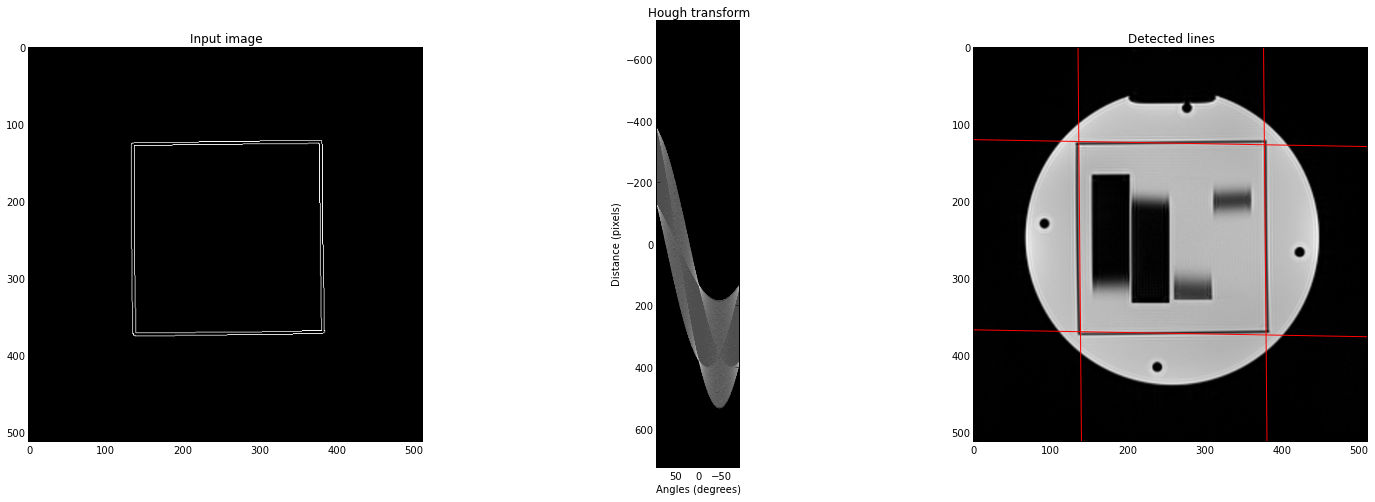

In [30]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.filter import canny
from skimage import data

import numpy as np
import matplotlib.pyplot as plt


# Classic straight-line Hough transform
image = images[9].copy()
edges = filter.canny(image, sigma=1, low_threshold=0.5, high_threshold=0.8)
edges = where(rect_mask_outer>0, edges, 0)
edges = where(rect_mask_inner>0, 0, edges)
h, theta, d = hough_line(edges)

plt.figure(figsize=(24, 8))

plt.subplot(131)
plt.imshow(edges, cmap=plt.cm.gray)
plt.title('Input image')

plt.subplot(132)
plt.imshow(np.log(1 + h),
           extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
                   d[-1], d[0]],
           cmap=plt.cm.gray, aspect=1/1.5)
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')

plt.subplot(133)
plt.imshow(image, cmap=plt.cm.gray)
rows, cols = image.shape
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, min_distance=75, num_peaks=4)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r')
plt.axis((0, cols, rows, 0))
plt.title('Detected lines')
# May have cols and rows mixed up - looks like the 'angle' is back to front

This doesn't really work very well as we get a double edge from the box. We'd really like just a single edge along the centre of the line.
We could do that by inverting and then putting a mask over the lines. Could use a rectangular box at say 0.8 to 0.9

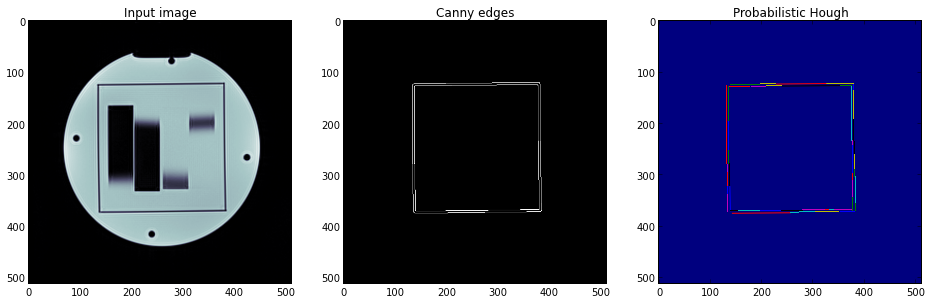

In [31]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)

image = images[9].copy()
edges = filter.canny(image, sigma=1.5, low_threshold=0.1, high_threshold=0.8)
edges = where(rect_mask_outer>0, edges, 0)
edges = where(rect_mask_inner>0, 0, edges)

lines = probabilistic_hough_line(edges, threshold=10, line_length=5, line_gap=3)

plt.figure(figsize=(16, 8))

plt.subplot(131)
plt.imshow(image, cmap='bone')
plt.title('Input image')

plt.subplot(132)
plt.imshow(edges, cmap='bone')
plt.title('Canny edges')

plt.subplot(133)
plt.imshow(edges * 0)

for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))

plt.title('Probabilistic Hough')
plt.axis('image')
plt.show()


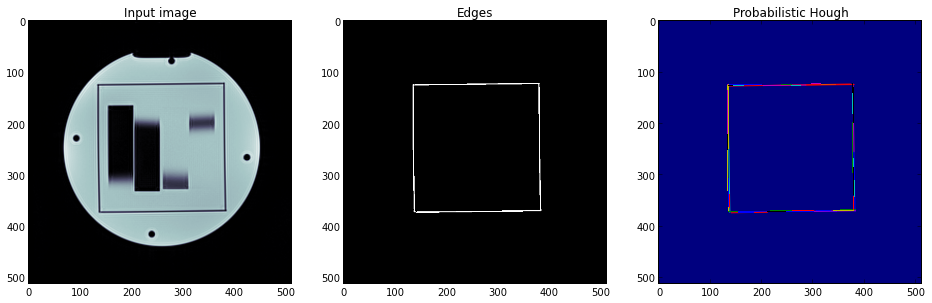

In [32]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line, resize)

from skimage.filter import threshold_otsu

image = images[9].copy()

edges = amax(image)-image
thresh = threshold_otsu(edges)
edges = where(rect_mask_outer>0, edges, 0)
edges = where(rect_mask_inner>0, 0, edges)
edges = (edges > thresh)

lines = probabilistic_hough_line(edges, threshold=10, line_length=5, line_gap=3)

plt.figure(figsize=(16, 8))

plt.subplot(131)
plt.imshow(image, cmap='bone')
plt.title('Input image')

plt.subplot(132)
plt.imshow(edges, cmap='bone')
plt.title('Edges')

plt.subplot(133)
plt.imshow(edges * 0)

for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))

plt.title('Probabilistic Hough')
plt.axis('image')
plt.show()

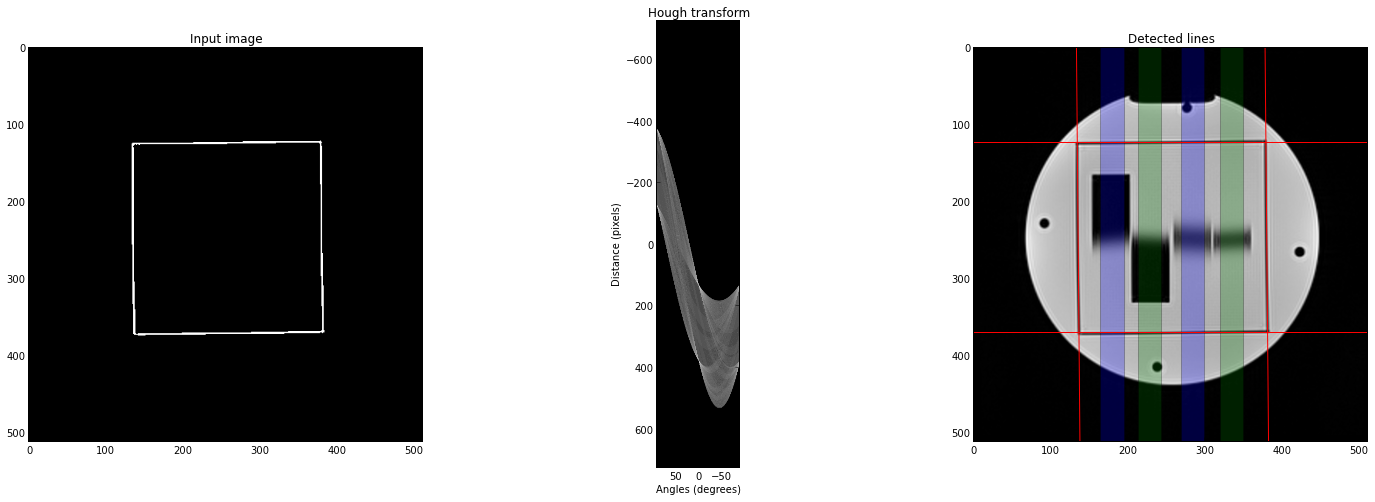

In [38]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.filter import canny
from skimage import data

import numpy as np
import matplotlib.pyplot as plt

from skimage.filter import threshold_otsu

image = images[11].copy()

edges = amax(image)-image
thresh = threshold_otsu(edges)
edges = where(rect_mask_outer>0, edges, 0)
edges = where(rect_mask_inner>0, 0, edges)
edges = (edges > thresh)

h, theta, d = hough_line(edges)

plt.figure(figsize=(24, 8))

plt.subplot(131)
plt.imshow(edges, cmap=plt.cm.gray)
plt.title('Input image')

plt.subplot(132)
plt.imshow(np.log(1 + h),
           extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
                   d[-1], d[0]],
           cmap=plt.cm.gray, aspect=1/1.5)
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')

plt.subplot(133)
plt.imshow(image, cmap=plt.cm.gray)
rows, cols = image.shape
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, min_distance=75, num_peaks=4)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r')
plt.axis((0, cols, rows, 0))
plt.title('Detected lines')

plate_1_start, plate_1_end = 270, 300
plate_2_start, plate_2_end = 320, 350
axvspan(plate_1_start, plate_1_end, facecolor='b', alpha=0.25)
axvspan(plate_2_start, plate_2_end, facecolor='g', alpha=0.25)

wedge_1_start, wedge_1_end = 164, 196
wedge_2_start, wedge_2_end = 214, 244
axvspan(wedge_1_start, wedge_1_end, facecolor='b', alpha=0.25)
axvspan(wedge_2_start, wedge_2_end, facecolor='g', alpha=0.25)

# May have cols and rows mixed up - looks like the 'angle' is back to front

FWHM (1) =  47.1970050539 pixels, or 4.77247552416 mm
FWHM (2) =  35.1011081218 pixels, or 3.54936037129 mm
FWHM (GMEAN) =  40.7021765686 pixels, or 4.11573025093 mm


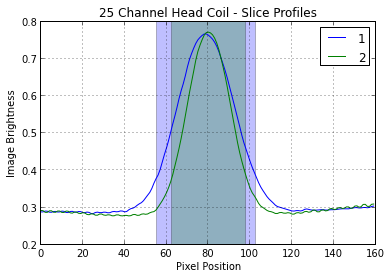

In [47]:
image = images[11].copy()
image = amax(image) - image
profile_1 = np.mean(image[170:330, plate_1_start:plate_1_end], axis=1)
profile_2 = np.mean(image[170:330, plate_2_start:plate_2_end], axis=1)
plot(profile_1, label='1')
hold(True)
plot(profile_2, label='2')
xlabel('Pixel Position')
ylabel('Image Brightness')
title('25 Channel Head Coil - Slice Profiles')
legend()
grid(True)

from scipy.interpolate import UnivariateSpline

# create a spline of x and blue-np.max(blue)/2 
spline = UnivariateSpline(range(len(profile_1)), profile_1-amax(profile_1)/2, s=0)
r1, r2 = spline.roots() # find the roots
axvspan(r1, r2, facecolor='b', alpha=0.25)
fwhm_1_pixels = (r2-r1)


spline = UnivariateSpline(range(len(profile_2)), profile_2-amax(profile_2)/2, s=0)
r1, r2 = spline.roots() # find the roots
axvspan(r1, r2, facecolor='g', alpha=0.25)
fwhm_2_pixels = (r2-r1)

xspacing, yspacing =  dobjs[0].PixelSpacing
plate_angle = 11.7 # degrees

fwhm_1_mm = fwhm_1_pixels * yspacing * tan(radians(plate_angle)) / 2 
fwhm_2_mm = fwhm_2_pixels * yspacing * tan(radians(plate_angle)) / 2

from scipy.stats.mstats import gmean
print 'FWHM (1) = ', fwhm_1_pixels, 'pixels, or', fwhm_1_mm, 'mm'
print 'FWHM (2) = ', fwhm_2_pixels, 'pixels, or', fwhm_2_mm, 'mm'
print 'FWHM (GMEAN) = ', gmean([fwhm_1_pixels,fwhm_2_pixels]) , 'pixels, or', gmean([fwhm_1_mm, fwhm_2_mm]), 'mm'

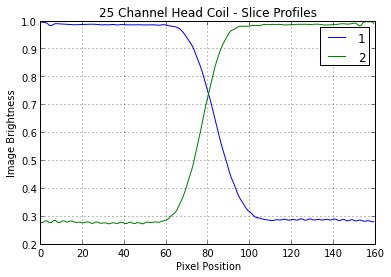

In [48]:
image = images[11].copy()
image = amax(image) - image
profile_1 = np.mean(image[170:330, wedge_1_start:wedge_1_end], axis=1)
profile_2 = np.mean(image[170:330, wedge_2_start:wedge_2_end], axis=1)
plot(profile_1, label='1')
hold(True)
plot(profile_2, label='2')
xlabel('Pixel Position')
ylabel('Image Brightness')
title('25 Channel Head Coil - Slice Profiles')
legend()
grid(True)

FWHM (1) =  22.0651272977 pixels, or 2.23118564081 mm
FWHM (2) =  17.9179891531 pixels, or 1.81183455556 mm
FWHM (GMEAN) =  19.8837298207 pixels, or 2.01060668553 mm


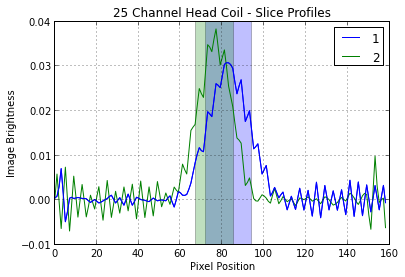

In [54]:
image = images[11].copy()
image = amax(image) - image

eprofile_1 = np.mean(image[170:330, wedge_1_start:wedge_1_end], axis=1)
eprofile_2 = np.mean(image[170:330, wedge_2_start:wedge_2_end], axis=1)
profile_1 = -diff(eprofile_1)
profile_2 = diff(eprofile_2)
plot(profile_1, label='1')
hold(True)
plot(profile_2, label='2')
xlabel('Pixel Position')
ylabel('Image Brightness')
title('25 Channel Head Coil - Slice Profiles')
legend()
grid(True)


from scipy.interpolate import UnivariateSpline

# create a spline of x and blue-np.max(blue)/2 
spline = UnivariateSpline(range(len(profile_1)), profile_1-amax(profile_1)/2, s=0)
r1, r2 = spline.roots() # find the roots
axvspan(r1, r2, facecolor='b', alpha=0.25)
fwhm_1_pixels = (r2-r1)
xs = range(len(profile_1))
plot(xs, spline(xs)+amax(profile_1)/2, color='b') 
# oops - doesn't seem to be smooothing

spline = UnivariateSpline(range(len(profile_2)), profile_2-amax(profile_2)/2, s=0)
r1, r2 = spline.roots() # find the roots
axvspan(r1, r2, facecolor='g', alpha=0.25)
fwhm_2_pixels = (r2-r1)

xspacing, yspacing =  dobjs[0].PixelSpacing
plate_angle = 11.7 # degrees

fwhm_1_mm = fwhm_1_pixels * yspacing * tan(radians(plate_angle)) / 2
fwhm_2_mm = fwhm_2_pixels * yspacing * tan(radians(plate_angle)) / 2

print 'FWHM (1) = ', fwhm_1_pixels, 'pixels, or', fwhm_1_mm, 'mm'
print 'FWHM (2) = ', fwhm_2_pixels, 'pixels, or', fwhm_2_mm, 'mm'

from scipy.stats.mstats import gmean
print 'FWHM (GMEAN) = ', gmean([fwhm_1_pixels,fwhm_2_pixels]) , 'pixels, or', gmean([fwhm_1_mm, fwhm_2_mm]), 'mm'

### Resolution Measurements on Eurospin TO4 in the 25 channel head coil.

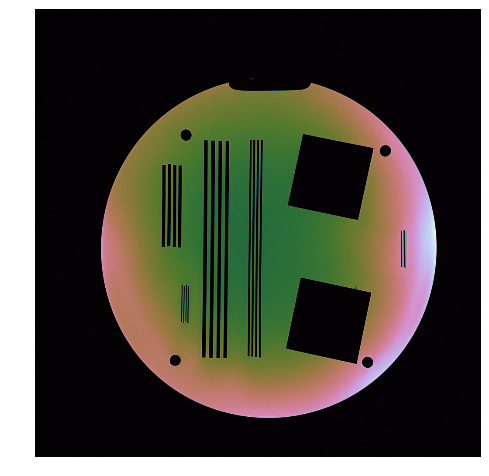

In [57]:
sernos = [71]
seriess = [s for s in qi.combo_find(server, patid) if s.seriesnumber in sernos]

# Fetch series from server to a temporary directory and read from there
from tempfile import mkdtemp
from shutil import rmtree
tempdir = mkdtemp()

# NB Returns a generator hence list() to force iteration
for series in seriess:
    list(qi.series_level_fetch(server,
                      patid=patid, studyuid=series.studyuid, seriesuid=series.seriesuid,
                      savedir=tempdir))

dobjs = sorted(dcmio.read_series(tempdir, globspec='*'), key=lambda d: (d.SeriesNumber, d.InstanceNumber))
rmtree(tempdir)

image = [d.pixel_array & 0xfff for d in dobjs][0]

fig, ax = subplots(1, 1, figsize=(8,8))

im = ax.imshow(image, cmap='cubehelix')
ax.axis('image')
ax.axis('off')
axs.set_title(r'Series %d, Image %d' % (dobjs[0].SeriesNumber, dobjs[0].InstanceNumber))



In [62]:
from skimage import filter
from skimage.transform import hough_circle
from skimage.feature import peak_local_max

def find_phantom(image, expected_radius):
    '''Locate phantom in image, Returns centre and radius.
    '''
    edges = filter.canny(image, sigma=3, low_threshold=0.1, high_threshold=0.9)
    rmin, rmax = int(round(expected_radius*0.95)), int(round(expected_radius*1.05))
    hough_radii = np.arange(rmin, rmax, 4)
    hough_res = hough_circle(edges, hough_radii)

    centres = []
    accums  = []
    radii   = []

    for r, h in zip(hough_radii, hough_res):
        # For each radius, extract two circles
        peaks = peak_local_max(h, num_peaks=2)
        centres.extend(peaks)
        accums.extend(h[peaks[:, 0], peaks[:, 1]])
        radii.extend([r, r])

    idx = np.argsort(accums)[::-1][0]

    centre_x, centre_y = centres[idx]
    radius = radii[idx]
    return centre_x, centre_y, radius


In [ ]:

# could do with some sort of phantom description dictionary in millimetres
# we'll divide through by the pixel dimensions
TO4 = {
   'mtf0':   ((x0, dx), y0, dy),
   'mtf1':   (x0, dx, y0, dy),
   'bar2mm': (x0, dx, y0, dy),
   'bar4mm': (x0, dx, y0, dy),
}


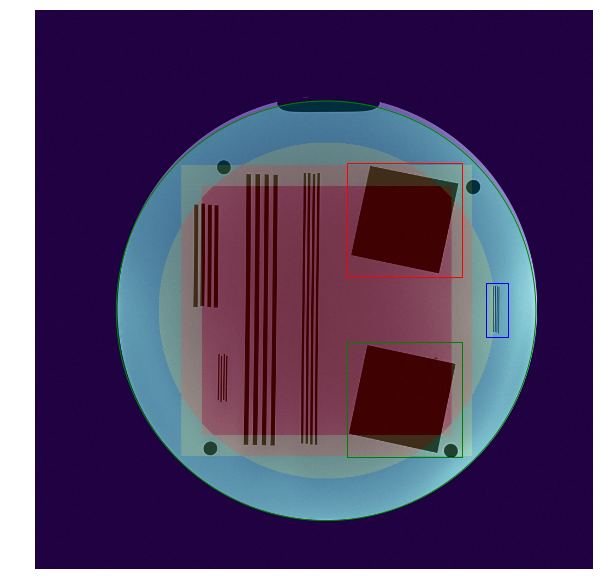

In [79]:
centre_x, centre_y, radius = find_phantom(image, expected_radius=380)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10))

ax.imshow(image, cmap='bone')
ax.axis('off')
ax.axis('image')

ax.add_artist(Circle((centre_y, centre_x), radius=radius, color='g', fill=False))
    
from skimage.draw import circle, polygon

circ_mask = np.zeros(image.shape, dtype=np.uint8)
circ_mask[circle(centre_x, centre_y, radius)] = 1
circ_mask_inner = np.zeros(image.shape, dtype=np.uint8)
circ_mask_inner[circle(centre_x, centre_y, 0.8*radius)] = 1
rect_mask_inner = np.zeros(image.shape, dtype=np.uint8)
r2 = radius*sqrt(0.5)*0.84
px = array([centre_x-r2, centre_x+r2, centre_x+r2, centre_x-r2])
py = array([centre_y-r2, centre_y-r2, centre_y+r2, centre_y+r2])
rect_mask_inner[polygon(px, py)] = 1
rect_mask_outer = np.zeros(image.shape, dtype=np.uint8)
r2 = radius*sqrt(0.5)*0.98
px = array([centre_x-r2, centre_x+r2, centre_x+r2, centre_x-r2])
py = array([centre_y-r2, centre_y-r2, centre_y+r2, centre_y+r2])
rect_mask_outer[polygon(px, py)] = 1

ax.imshow(circ_mask+circ_mask_inner+rect_mask_inner+rect_mask_outer, alpha=0.25, cmap='rainbow')

ax.add_patch(Rectangle((575, 280), 210, 210, color='r', fill=False))
ax.add_patch(Rectangle((575, 610), 210, 210, color='g', fill=False))
ax.add_patch(Rectangle((830, 500), 40, 100, color='b', fill=False))

0.754189944134


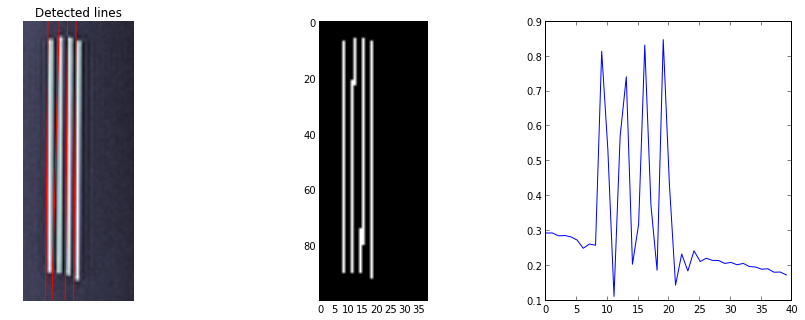

In [109]:
bar1 = image[500:600, 830:870]

bar1 = bar1.astype('float')
bar1 /= amax(bar1)

#edges = filter.canny(bar1, sigma=0.5, low_threshold=0.1, high_threshold=0.3)

bar1 = amax(bar1)-bar1
#edges = filter.vprewitt(bar1)
edges = diff(bar1, axis=1)
edges[edges<0] = 0
thresh = threshold_otsu(edges)
edges = (edges > thresh*1.25)
h, theta, d = hough_line(edges)


fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,5))

ax[0].imshow(bar1, cmap='bone')
ax[0].axis('off')
ax[0].axis('image')

ax[1].imshow(edges, cmap='bone')

angles = []
rows, cols = bar1.shape
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, min_distance=1, num_peaks=4)):
    angles.append(angle)
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    ax[0].plot((0, cols), (y0, y1), '-r')
    #plt.axis((0, cols, rows, 0))
    ax[0].set_title('Detected lines')

print np.degrees(np.mean(angles))
ax[2].plot(mean(bar1, axis=0))


In [69]:
from skimage.transform import rotate

def extract_object_rotated(image, x, nx, y, ny, shift=(0, 0), rotation=0):
    '''We rotate and shift the image
       x, nx, y, ny are in pixels.
       shift is the offset of the phantom position from the image centre.
       rotation is the rotation of the phantom image about its centre.
    '''
    shift_x, shift_y = shift
    image_centred = roll(roll(image, -shift_x, axis=1), -shift_y, axis=0)
    image_rotated = rotate(image, angle=np.radians(-rotation), order=2)
    return image_rotated[y:y+ny][x:x+nx]


def extract_object(image, x, nx, y, ny, shift=(0, 0), rotation=0):
    '''Extract a component of the phantom from an image.
       We rotate and shift the bounding box
       x, nx, y, ny are in pixels.
       shift is the offset of the phantom position from the image centre.
       rotation is the rotation of the phantom image about its centre.
    '''
    
    # Shift box along with phantom image
    shift_x, shift_y = shift
    x += shift_x
    y += shift_y
    
    # Rotate box around image centre by same amount as phantom
    centre_x, centre_y = image.shape[1]/2, image.shape[0]/2
    x1 = x - centre_x
    x2 = x1 + nx
    y1 = y - centre_y
    y2 = y1 + ny
    corners = [
        (x1, y1),
        (x1, y2),
        (x2, y2),
        (x2, y1)
    ]
    alpha = np.radians(rotation)
    corners = [
        (x * cos(alpha) - y * sin(alpha), x * sin(alpha) + y * cos(alpha)) for (x, y) in corners
    ]
    corners = asarray([
        (x + centre_x, y + centre_y) for (x, y) in corners
    ])
    
    # Recalculate bounding box
    x,   y = int(floor(amin(corners[:, 0]))), int(floor(amin(corners[:, 1])))
    nx, ny = int(ceil(amax(corners[:, 0]))),  int(ceil(amin(corners[:, 1])))

    return image[y:y+ny][x:x+nx]


### DTI Eddy Current Evaluation

In [ ]:
sernos = [30]
seriess = [s for s in qi.combo_find(server, patid) if s.seriesnumber in sernos]

# Fetch series from server to a temporary directory and read from there
from tempfile import mkdtemp
from shutil import rmtree
tempdir = mkdtemp()

# NB Returns a generator hence list() to force iteration
for series in seriess:
    list(qi.series_level_fetch(server,
                      patid=patid, studyuid=series.studyuid, seriesuid=series.seriesuid,
                      savedir=tempdir))

dobjs = sorted(dcmio.read_series(tempdir, globspec='*'), key=lambda d: (d.SeriesNumber, d.InstanceNumber))
rmtree(tempdir)

In [ ]:
# This will be a series of DTI images. We assume the first image is the B0, which we'll drop.
images = asarray([d.pixel_array & 0xfff for d in dobjs][1:], dtype=np.float64)

devn_image = np.std(images, axis=0)
mean_image = np.mean(images, axis=0)
mean_signal = np.mean(mean_image[100:150, 100:150])

print mean_signal
imshow(devn_image/mean_signal, cmap='jet')
colorbar()
axis('image')
axis('off')
title(r'Standard Deviation of Diffusion Tensor Images');

We could look for the distance over which the standard deviation is over a threshold. We want the range of the distortion really.

Tests
-----

1. Coil SNR
   - Comparison of Siemens Values
   - Subtraction image of standard acquisition
   - History of fMRIQA results for static SNR
2. Head Coil Uniformity using Silicone Oil
   - Need to fill DOH phantom with oil.
   - Scan with/without prescan normalise
3. Slice Thickness & Location
   - Profiles from blocks or cross ramps for 2D and 3D
   - Bath or Leeds phantoms
   - Curves + FWHM vs prescribed thickness
   - Spin Echo 2D
   - Flash3D ?
4. Geometry
5. Eddy Currents
6. Spectroscopy
7. Stability
8. Flow Imaging
9. DTI Stability
10. Ghosting
11. Spatial Resolution ?
12. Shim Quality
13. Body Coil Tuning ?
14. Squeeze bulb, Table Motion, Table Retract, Oxygen Monitor, Lights, Bore Ventilation, Patient Communication, Patient Monitoring CCTV
15. RF Interference, Spikes
16. Current centre frequency, drift
17. TX, check maximality of 90 pulse? eg GRE with long TR and flips over range, 
18. Accuracy of centre frequency?
19. Contiguous slices fo 'commononly used' pulse sequences -> look for artefacts: ghosts or central zippers.
20. TX stability? - Siemens Tools?
21. EC - check history of Siemens measurements
22. 



For Uniformity we need to determine the centroid of phantom image and approximately the width of the mask at that point. We then take a thick slice and sum it into a profile.
We need then to set a threshold to restrict the profile to the interior of the phantom and then we can determine some parameters ala green book.

In [ ]:
import dicom as dcm
import dcmextras.seriesio as dcmio
import dcmextras.siemenscsa as csa
import dcmextras.siemensoog as oog

We'll need a standard directory layout fo the test images *or* a standard naming/numbering on the server so we can fetch them easily.

Protocols for Tests on DOH Phantoms

- Uniformity, SNR, ghosting:
 - 15 Channel Head/Neck, T01, SE Axial
 - 15 Channel Head/Neck, T01, SE Sagittal
 - 15 Channel Head/Neck, T01, SE Coronal
- Slice Thickness and Geometric Distortion:
 - 15 Channel Head/Neck, T02, SE Axial    SL=3mm
 - 15 Channel Head/Neck, T02, SE Axial    SL=5mm
 - 15 Channel Head/Neck, T02, SE Sagittal SL=3mm
 - 15 Channel Head/Neck, T02, SE Sagittal SL=5mm
 - 15 Channel Head/Neck, T02, SE Coronal  SL=3mm
 - 15 Channel Head/Neck, T02, SE Coronal  SL=3mm
- Slice Warp
 - 15 Channel Head/Neck, T03, SE Axial    SL=2mm
 - 15 Channel Head/Neck, T03, SE Sagittal SL=2mm
 - 15 Channel Head/Neck, T03, SE Coronal  SL=2mm
- Resolution:
 - 15 Channel Head/Neck, T04, SE Axial    DX=1mm
 - 15 Channel Head/Neck, T04, SE Axial    DX=0.25mm
 - 15 Channel Head/Neck, T04, SE Sagittal DX=1mm
 - 15 Channel Head/Neck, T04, SE Sagittal DX=0.25mm
 - 15 Channel Head/Neck, T04, SE Coronal  DX=1mm
 - 15 Channel Head/Neck, T04, SE Coronal  DX=0.25mm

- Uniformity, SNR, ghosting:
 - 32 Channel Head,      Oil-Sphere, SE Axial
 - 32 Channel Head,      Oil-Sphere, SE Sagittal
 - 32 Channel Head,      Oil-Sphere, SE Coronal
- DWI Eddy Current test
 - 32 Channel Head, Oil-Sphere, DTI-SE-EPI Axial
 - 32 Channel Head, Oil-Sphare, DTI-SE-EPI Sagittal
 - 32 Channel Head, Oil-Sphere, DTI-SE-EPI Coronal

Siemens QA

- Coil QA on all coils especially Head Coils and Body Arrays
 - 

In [3]:
from mriqa import phantoms

In [5]:
phantoms.T01

{'Diameter': 200,
 'Features': {'Hole1': ((100, 0), (5, 5)),
  'Hole2': ((0, 100), (5, 5)),
  'Hole3': ((-100, 0), (5, 5)),
  'Hole4': ((0, -100), (5, 5))}}

In [12]:
from mriqa import dcmio

In [13]:
dir(dcmio)

['AetTable',
 'QueryInterface',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'division',
 'fetch_series',
 'mkdtemp',
 'os',
 'platform',
 'read_series',
 'rmtree']